In [1]:
import pm4py
import pandas as pd
import datetime
from math import ceil
import matplotlib.pyplot as plt
import torch
import numpy as np
import gym
from importlib import reload
import random
from random import shuffle

import rl4pm_lib.preprocessing as preprocessing
reload(preprocessing)
from IPython import display

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
cpu = torch.device("cpu")

# Data
## Download and read
- Download `.xes` file(archive) from [here](https://data.4tu.nl/articles/dataset/BPI_Challenge_2012/12689204)
- Read this `.xes`
- Convert to good old `.csv`

## Drop data
In the article only (activity, time_stamp) is used. Also leave trace id

In [4]:
try:
    df = pd.read_csv('bpi_12_preprocessed.csv')
    
except FileNotFoundError:
    file_path = 'BPI_Challenge_2012.xes'
    event_log = pm4py.read_xes(file_path)
    start_activities = pm4py.get_start_activities(event_log)
    end_activities = pm4py.get_end_activities(event_log)
    df = pm4py.convert_to_dataframe(event_log)
    df = df[['time:timestamp', 'case:concept:name', 'concept:name']]
    df = df.rename(columns={'time:timestamp': 'timestamp', 'case:concept:name': 'trace_id', 'concept:name': 'activity'})
    df['trace_id'] = df['trace_id'].apply(lambda x: int(x))
    df.to_csv('bpi_12.csv', index=False)
    prepro = preprocessing.DfPreprocesser()
    prepro.fit(df)
    df = prepro.transform(df)
    df.to_csv('bpi_12_preprocessed.csv', index=False)

In [5]:
n_classes = df.drop(columns=['te', 'tw', 'tt', 'trace_id']).shape[1]
n_classes

24

In [6]:
window_size = 2

## Time-related features

- $t_{w}$ - time passed between Sunday midnight and the event
- $t_e$ - time passed between the completion of the given event and the completion of the previous one
- $t_t$ - time passed between the start of the trace and the given event


## Scaling
env will scale time-related features

In [7]:
column_feature = {'te': 0, 'tt': 1, 'tw': 2}
scaler = preprocessing.PaperScaler(column_features=column_feature)
scaler.fit(df)

## Environment
Ther given scheme is the following:
- recieving window of $(a_i,\ t_{e,\ i},\ t_{w,\ i},\ t_{t,\ i}) = e_i$. So the input to model is $\{ e_{i},\ e_{i-1},\ \dots,\ e_{i-ws} \}$ 
- prodice $\hat{e}_{i+1}$
- predict $\hat{e}_{i+2}$ using $\{ \hat{e}_{i+1},\ e_{i},\ \dots,\ e_{i-ws +1} \}$
The metric is calculated by `environment`. It returns rewards for time prediction and for next step classifiation. So basicly `env` just stores data of trace. 

In [8]:
te_key_times = [0., 1., 10., 60., 120., 240., 480., 1440., 2880., 4320.,
                7200., 10080., 14400., 20160., 30240., 40320., 50400.]
te_intervals = [(te_key_times[i], te_key_times[i+1])
             for i in range(len(te_key_times)-1)]

```python
input = (n_traces, max_len, features) # nn.LSTM(..., batch_first=True)
```

```python
output = out, (h, c)
out.shape = (n_traces, max_len, features) # nn.LSTM(..., batch_first=True)
```

### Loop with env, LSTM

In [9]:
df.shape

(262200, 28)

In [10]:
'''from rl4pm_lib import envs
reload(envs)
env = envs.PMEnv(data=env_matrix, intervals_te_rew=te_intervals, column_to_time_features=column_feature,
                 window_size=window_size, device=cpu, scaler=scaler)

lstm_model_te = Net(output_layer=1).float()
lstm_model_act = Net(output_layer=n_classes).float()

inp = env.reset()
n_traces = inp.shape[0]
# predictor is a NN, it works with batches of states
is_done = torch.zeros(env_matrix.shape[0]).bool()
h_a = torch.zeros(1, n_traces, 64)
c_a = torch.zeros(1, n_traces, 64)
h_te = torch.zeros(1, n_traces, 64)
c_te = torch.zeros(1, n_traces, 64)
while not is_done.all():
    inp = inp.view(n_traces, 1, -1).float()
    next_act, (h_a, c_a) = lstm_model_act(inp, (h_a, c_a))
    next_te, (h_te, c_te) = lstm_model_te(inp, (h_te, c_te))
    
    next_act = next_act.view(n_traces, -1)
    next_act = next_act.argmax(dim=1).view(n_traces, -1)
    
    next_te = next_te.view(n_traces)
        
    inp, (reward_te, reward_act), is_done, add_inf = env.step((next_te, next_act))'''

'from rl4pm_lib import envs\nreload(envs)\nenv = envs.PMEnv(data=env_matrix, intervals_te_rew=te_intervals, column_to_time_features=column_feature,\n                 window_size=window_size, device=cpu, scaler=scaler)\n\nlstm_model_te = Net(output_layer=1).float()\nlstm_model_act = Net(output_layer=n_classes).float()\n\ninp = env.reset()\nn_traces = inp.shape[0]\n# predictor is a NN, it works with batches of states\nis_done = torch.zeros(env_matrix.shape[0]).bool()\nh_a = torch.zeros(1, n_traces, 64)\nc_a = torch.zeros(1, n_traces, 64)\nh_te = torch.zeros(1, n_traces, 64)\nc_te = torch.zeros(1, n_traces, 64)\nwhile not is_done.all():\n    inp = inp.view(n_traces, 1, -1).float()\n    next_act, (h_a, c_a) = lstm_model_act(inp, (h_a, c_a))\n    next_te, (h_te, c_te) = lstm_model_te(inp, (h_te, c_te))\n    \n    next_act = next_act.view(n_traces, -1)\n    next_act = next_act.argmax(dim=1).view(n_traces, -1)\n    \n    next_te = next_te.view(n_traces)\n        \n    inp, (reward_te, reward_

## Agncy
Here agent got trained

In [11]:
# replay_memory.sample(1)[0]['s'].shape

In [12]:
'''from rl4pm_lib import envs
reload(envs)
from rl4pm_lib import agents
reload(agents)
from rl4pm_lib import agencies
reload(agencies)
from rl4pm_lib import envs
reload(envs)
from rl4pm_lib import utils
reload(utils)
batch_size = 128
# TODO case env.device = cpu, process_device = cuda
env = envs.PMEnv(data=env_matrix, intervals_te_rew=te_intervals, column_to_time_features=column_feature,
                 window_size=window_size, device=cpu, scaler=scaler)

agency = agencies.Agency(input_size=27 * 2, hidden=hidden, n_lstm=7, te_intervals=te_intervals, ac_learning_rate=1e-3,
                         te_learning_rate=1e-3, n_classes=n_classes, discount_factor=0.9)
replay_memory = replay_buffer.ReplayMemory(2 ** 12, traces=8)

with torch.no_grad():
    episode_te_rew, episode_ac_rew, n = utils.play_and_record(agency.te_agent, agency.ac_agent, env, replay_memory,
                                                              process_dvice=cpu, dest_device=cpu
                                                             )
ep_te_loss, ep_ac_loss = agency.train(replay_memory, batch_size)'''

'from rl4pm_lib import envs\nreload(envs)\nfrom rl4pm_lib import agents\nreload(agents)\nfrom rl4pm_lib import agencies\nreload(agencies)\nfrom rl4pm_lib import envs\nreload(envs)\nfrom rl4pm_lib import utils\nreload(utils)\nbatch_size = 128\n# TODO case env.device = cpu, process_device = cuda\nenv = envs.PMEnv(data=env_matrix, intervals_te_rew=te_intervals, column_to_time_features=column_feature,\n                 window_size=window_size, device=cpu, scaler=scaler)\n\nagency = agencies.Agency(input_size=27 * 2, hidden=hidden, n_lstm=7, te_intervals=te_intervals, ac_learning_rate=1e-3,\n                         te_learning_rate=1e-3, n_classes=n_classes, discount_factor=0.9)\nreplay_memory = replay_buffer.ReplayMemory(2 ** 12, traces=8)\n\nwith torch.no_grad():\n    episode_te_rew, episode_ac_rew, n = utils.play_and_record(agency.te_agent, agency.ac_agent, env, replay_memory,\n                                                              process_dvice=cpu, dest_device=cpu\n            

In [13]:
from math import floor, ceil

In [14]:
def split_list_to_buckets(array, n):
    n_buckets = ceil(len(array) / n)
    n_full_buckets = floor(len(array) / n)
    extra_size = n_buckets * n - len(array)
    out = []
    fp = 0
    lp = n
    for i in range(n_buckets):
        lp = lp - int(extra_size > 0)
        out.append(array[fp: lp])
        extra_size -= 1
        fp = lp
        lp += n
    return out

In [15]:
traces = list(set(df['trace_id'].values))
traces_len = {}
for t in traces:
    trace_len = df[df['trace_id'] == t].shape[0]
    if trace_len > window_size:
        traces_len[t] = df[df['trace_id'] == t].shape[0]

    
traces_len_sorted = dict(sorted(traces_len.items(), key=lambda item: item[1]))
traces = list(traces_len_sorted.keys())

In [16]:
def split_to_fixed_bucket(array, bucket_size, fill_none=True):
    index = len(array)
    out = []
    while index > 0:
        beg = max(0, index - bucket_size)
        end = index
        out.append(array[beg: end])
        index -= bucket_size
    out[-1].extend([None] * (-1 * index))
    return out

In [17]:
split_to_fixed_bucket([1, 2, 3, 4, 5, 6, 7, 8], 3)

[[6, 7, 8], [3, 4, 5], [1, 2, None]]

In [20]:
from rl4pm_lib import envs, utils
reload(envs)
reload(utils)
traces = list(set(df['trace_id'].values))
shuffle(traces)
# traces = traces[:2048]
n_traces = 256

ix_4_envs = split_to_fixed_bucket(traces, n_traces)
n_envs = len(ix_4_envs)
envirs = []
for _i in range(n_envs):
    print(f'{_i+1}/{n_envs}', end='\r')
    env_matrix = utils.get_traces_matrix(df, ix_4_envs[_i])
    envirs.append(envs.PMEnv(data=env_matrix, intervals_te_rew=te_intervals, column_to_time_features=column_feature,
                             window_size=window_size, device=cpu, scaler=scaler
                            )
               )

In [24]:
from rl4pm_lib import replay_buffer, agents, agencies
reload(agents)
reload(agencies)
batch_size = 2 ** 10
hidden = 64
replay_memory = replay_buffer.ReplayMemory(2 ** 20 // n_traces, n_traces)
agency = agencies.Agency(input_size=27 * 2, hidden=hidden, n_lstm=1, te_intervals=te_intervals, ac_learning_rate=1e-3,
                         te_learning_rate=1e-3, n_classes=n_classes, discount_factor=0.9)

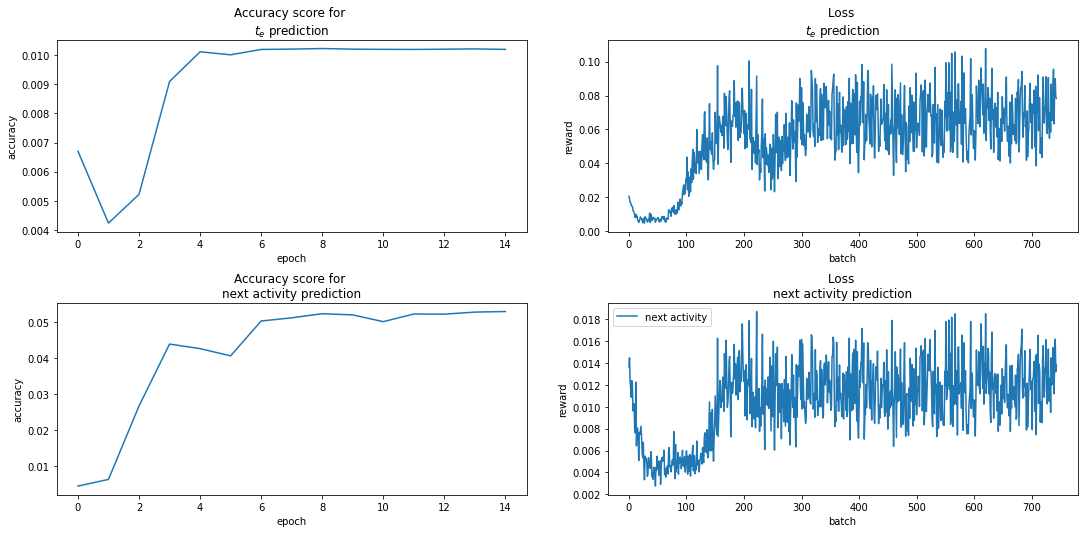

KeyboardInterrupt: 

In [25]:
wtf = []
te_rewards = []
ac_rewards = []
nn_rewards = []
losses_ac = []
losses_te = []
loc_te_rews = []
loc_ac_rews = []
loc_n_ = []
for epoch in range(40):
    te_rw = 0
    ac_rw = 0
    n = 0
    for _i in range(n_envs):
        print(f'{_i+1}/{n_envs}', end='\r')
        _ = envirs[_i].reset()
        with torch.no_grad():
            _episode_te_rew, _episode_ac_rew, n_ep = utils.play_and_record(agency.te_agent, agency.ac_agent,
                                                                           envirs[_i], replay_memory,
                                                                           process_dvice=cpu, dest_device=cpu,
                                                                           stoch=False
                                                                          )

        if (n_ep < _episode_ac_rew) | (n_ep < _episode_te_rew):
            wtf.append(len(loc_te_rews))
        loc_te_rews.append(_episode_te_rew)
        loc_ac_rews.append(_episode_ac_rew)
        loc_n_.append(n_ep)
        te_rw += _episode_te_rew
        ac_rw += _episode_ac_rew
        n += n_ep
        if replay_memory.is_full():
            agency.to(device)
            ep_te_loss, ep_ac_loss = agency.train(replay_memory, batch_size)
            losses_ac.append(ep_ac_loss)
            losses_te.append(ep_te_loss)
        # print(ep_te_rew, ep_te_rew, n_samples)
    
    agency.to(device)
    ep_te_loss, ep_ac_loss = agency.train(replay_memory, batch_size)
    te_rewards.append(te_rw / n)
    ac_rewards.append(ac_rw / n)
    nn_rewards.append(n)
    
    display.clear_output(wait=True)
    
    fig, axs = plt.subplots(2, 2, figsize=(16,8))
    fig.tight_layout(pad=5)
    axs[0, 0].plot(te_rewards, label='$t_e$')
    axs[0, 0].set(xlabel='epoch', ylabel='accuracy', title='Accuracy score for \n$t_e$ prediction')
    axs[1, 0].plot(ac_rewards, label='next activity')
    axs[1, 0].set(xlabel='epoch', ylabel='accuracy', title='Accuracy score for \nnext activity prediction')
    
    
    axs[0, 1].plot(losses_ac, label='$t_e$')
    axs[0, 1].set(xlabel='batch', ylabel='reward', title='Loss \n$t_e$ prediction')
    axs[1, 1].plot(losses_te, label='next activity')
    axs[1, 1].set(xlabel='batch', ylabel='reward', title='Loss \nnext activity prediction')
    plt.legend()
    plt.show()

In [ ]:
# x = np.linspace(0, 2 * np.pi, 400)
# y = np.sin(x ** 2)
# fig, axs = plt.subplots(2, 2, figsize=(16,8))
# fig.tight_layout(pad=4)
# axs[0, 0].plot(x, y)
# axs[0, 0].set_title('Axis [0,0]\nlol')
# axs[0, 1].plot(x, y, 'tab:orange')
# axs[0, 1].set_title('Axis [0,1]')
# axs[1, 0].plot(x, -y, 'tab:green')
# axs[1, 0].set_title('Axis [1,0]')
# axs[1, 1].plot(x, -y, 'tab:red')
# axs[1, 1].set_title('Axis [1,1]\nkek')

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()